In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D


%matplotlib inline

pd.options.display.max_rows = 20

In [2]:
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')

In [3]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,201903,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Enplaned,Other,International,A,6995
1,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Enplaned,Other,International,A,12172
2,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Deplaned,Other,International,A,11496
3,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Enplaned,Other,International,G,7473
4,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Deplaned,Other,International,G,6857


In [4]:
df.shape

(20256, 12)

In [5]:
# Dropping nulls that I found in columns - only a few
df.dropna(inplace = True)

In [6]:
df.columns

Index(['Activity Period', 'Operating Airline', 'Operating Airline IATA Code',
       'Published Airline', 'Published Airline IATA Code', 'GEO Summary',
       'GEO Region', 'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count'],
      dtype='object')

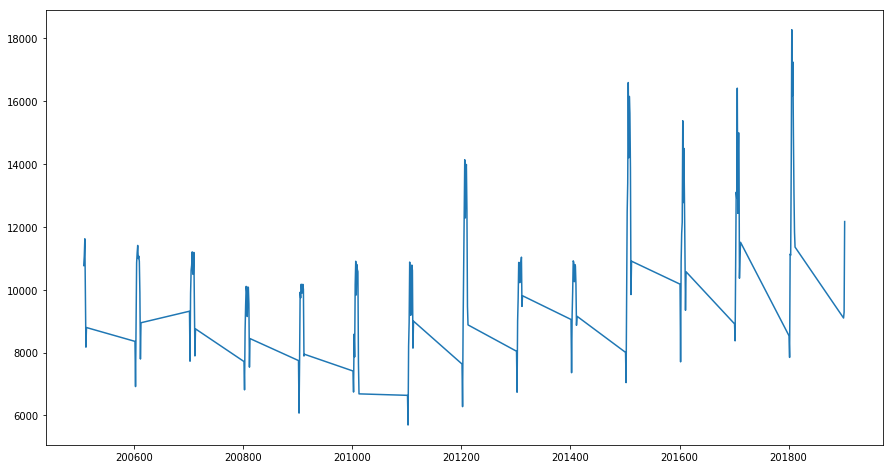

In [7]:
# Plotting one airline's flights against time to see how the time series look

df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Plot of passengers leaving SFO on Virgin Atlantic
plt.figure(figsize = (15,8))
plt.plot(df_explore_virgin['Activity Period'], df_explore_virgin['Passenger Count']);

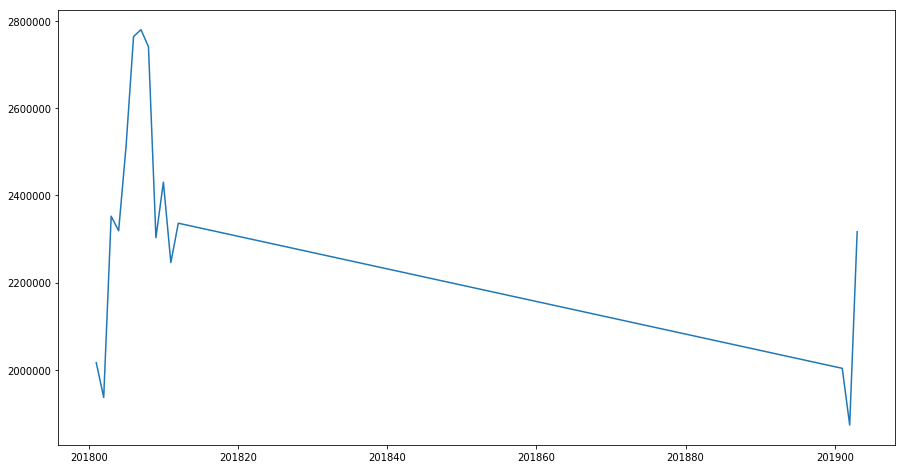

In [8]:
df_explore = df[df['Activity Type Code'] == 'Enplaned'].groupby('Activity Period').sum()

df_explore = df_explore[df_explore.index >= 201800]

# Zoomed-in version shows that it is interpreting the difference between "201812" and "201901" incorrectly
plt.figure(figsize = (15,8))
plt.plot(df_explore.index, df_explore['Passenger Count']);

# Data Cleaning

In [9]:
df['date'] = pd.to_datetime(df['Activity Period'], format = '%Y%m')

In [10]:
# Eliminating rows that account for passengers in layovers. Don't care about those
df.set_index('Activity Type Code', inplace = True)
df.drop(index = 'Thru / Transit', inplace = True)

In [11]:
# Changing the index to dates so that I can use time-series unique functions like pd.resample()
df.reset_index(inplace = True)

# Dropping the no longer useful column that we derived dates from
df.drop(columns = 'Activity Period', inplace = True)

In [12]:
# Cleaning up the name of the 'United Airlines' that is pre-2013
df.replace('United Airlines - Pre 07/01/2013', 'United Airlines', inplace = True)

## Next up: I need to group by the proper types so I can get "enplaned" and "deplaned" trends, and conduct separate time series analysis on them

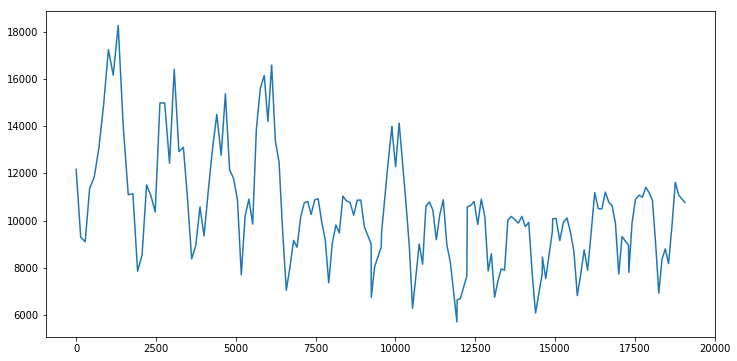

In [13]:
df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic')  & (df['Activity Type Code'] == 'Enplaned')]

# Improved plot of Virgin Atlantic after datetime was fixed
plt.figure(figsize = (12,6))
plt.plot(df_explore_virgin.index, df_explore_virgin['Passenger Count']);

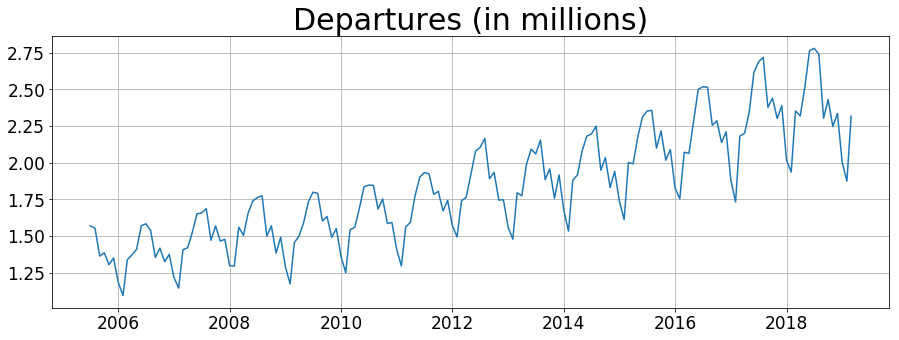

In [167]:
enplaned = df[df['Activity Type Code'] == 'Enplaned'].groupby('date').sum()

# Improved plot of total air traffic after datetime was fixed

plt.figure(figsize = (15,5))
sns.lineplot(enplaned.index, enplaned['Passenger Count'] / 1000000)
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.savefig('img/sfo_traffic.png', bbox_inches = 'tight')

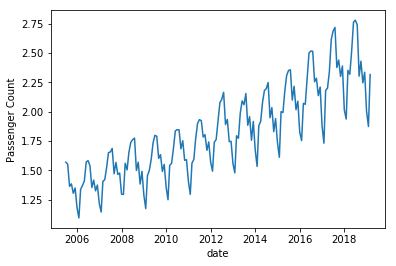

In [16]:
sns.lineplot(enplaned.index, enplaned['Passenger Count'] / 1000000)

## Operating Airline vs Published Airline

In [17]:
# A company like SkyWest Airline is never a Published Airline - only an Operating Airline
df.loc[df['Operating Airline'] == 'SkyWest Airlines', 'Published Airline'].unique()

array(['United Airlines', 'Alaska Airlines', 'Delta Air Lines',
       'American Airlines'], dtype=object)

In [18]:
df['Operating Airline'].value_counts()

United Airlines                     3295
SkyWest Airlines                    1292
Alaska Airlines                      820
Virgin America                       462
Delta Air Lines                      446
Air Canada                           438
American Airlines                    416
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Jet Airways                           16
Miami Air International               16
Allegiant Air                         16
Air Canada Jazz                       14
Independence Air                      10
World Airways                          3
Xtra Airways                           2
Evergreen International Airlines       2
Norwegian Air UK Ltd                   2
Atlas Air, Inc                         1
Name: Operating Airline, Length: 84, dtype: int64

In [19]:
df['Published Airline'].value_counts()

United Airlines                     4182
Alaska Airlines                     1178
Delta Air Lines                      990
American Airlines                    660
Air Canada                           520
Virgin America                       462
US Airways                           407
JetBlue Airways                      337
Sun Country Airlines                 335
Frontier Airlines                    332
                                    ... 
Icelandair EHF                        20
Jet Airways                           16
Miami Air International               16
Allegiant Air                         16
Independence Air                      10
World Airways                          3
Xtra Airways                           2
Evergreen International Airlines       2
Norwegian Air UK Ltd                   2
Atlas Air, Inc                         1
Name: Published Airline, Length: 74, dtype: int64

In [20]:
# Shows that Operating Airline is different from Published Airline ~2000 times: 1/10 of the time in my df
df[df['Operating Airline'] != df['Published Airline']]

,Activity Type Code,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Price Category Code,Terminal,Boarding Area,Passenger Count,date
39,Enplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3363,2019-03-01
40,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,Terminal 3,F,3262,2019-03-01
41,Deplaned,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Other,International,G,3191,2019-03-01
42,Enplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,167195,2019-03-01
43,Deplaned,SkyWest Airlines,OO,United Airlines,UA,Domestic,US,Other,Terminal 3,F,172593,2019-03-01
44,Enplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18534,2019-03-01
45,Deplaned,SkyWest Airlines,OO,Alaska Airlines,AS,Domestic,US,Other,Terminal 2,D,18142,2019-03-01
46,Enplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8263,2019-03-01
47,Deplaned,SkyWest Airlines,OO,Delta Air Lines,DL,Domestic,US,Other,Terminal 1,C,8496,2019-03-01
68,Enplaned,Jazz Aviation,QK,Air Canada,AC,International,Canada,Other,International,G,7719,2019-03-01


**I will use Operating Airlines since that indicates who is actually flying the flight. The Published Airline is the one who is marketing the flight, and Operating is the one who is actually flying it. Individuals know that the flight is being operated by SkyWest Airlines, for instance, even if they bought the ticket from United.**

In [21]:
# Autocorrelation across all airlines is very close to 1
enplaned['Passenger Count'].autocorr(lag = 12)

0.9827490118965926

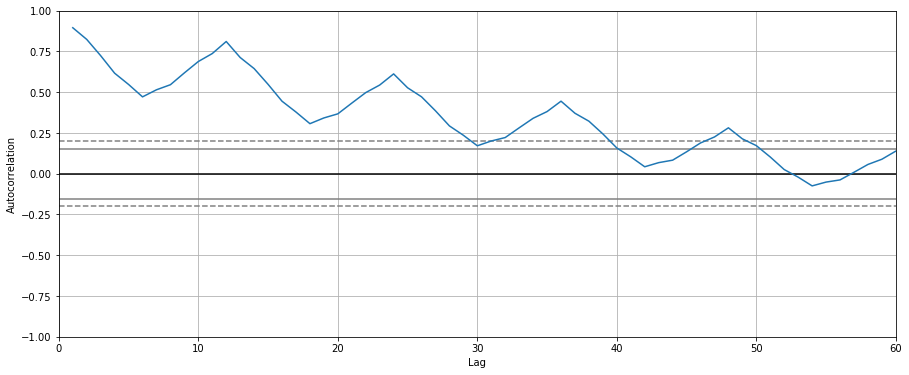

In [22]:
# We definitely have autocorrelation - peaking at the 12 month mark and the 1 month mark
plt.figure(figsize = (15,6))
pd.plotting.autocorrelation_plot(enplaned['Passenger Count'])
plt.xlim(0,60);

## Differencing

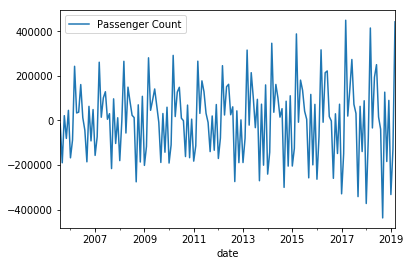

In [23]:
enplaned.diff().dropna().plot();

## Check for stationarity

Aiming for an autocorrelation that is approximately 0, and not more negative that -0.5, per https://people.duke.edu/~rnau/411arim2.htm

In [24]:
print(enplaned['Passenger Count'].autocorr())
print(enplaned['Passenger Count'].diff().autocorr()) # Autocorrelation approx == 0
print(enplaned['Passenger Count'].diff().diff().autocorr())

0.9009954328098658
-0.12716916391020128
-0.6064341398992737


In [25]:
print(enplaned.std())
print(enplaned.diff().std()) # Std is at its lowest
print(enplaned.diff().diff().std())

Passenger Count    380995.515031
dtype: float64
Passenger Count    169512.571295
dtype: float64
Passenger Count    252641.798598
dtype: float64


Both of the above tests confirm that only one layer of differencing is needed in our model

### ARIMA guides for further work, if needed:

Textbooks:

https://people.duke.edu/~rnau/seasarim.htm

http://www.statsoft.com/Textbook/Time-Series-Analysis#1general

Articles:

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

Documentation examples:

https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html

In [28]:
df.head()

,Activity Type Code,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Price Category Code,Terminal,Boarding Area,Passenger Count,date
0,Enplaned,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Other,International,A,6995,2019-03-01
1,Enplaned,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Other,International,A,12172,2019-03-01
2,Deplaned,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Other,International,A,11496,2019-03-01
3,Enplaned,United Airlines,UA,United Airlines,UA,International,Middle East,Other,International,G,7473,2019-03-01
4,Deplaned,United Airlines,UA,United Airlines,UA,International,Middle East,Other,International,G,6857,2019-03-01


In [29]:
df_enplaned = df[df['Activity Type Code'] == 'Enplaned']
df_deplaned = df[df['Activity Type Code'] == 'Deplaned']

df_enplaned = df_enplaned.groupby(by = ['date', 'Operating Airline']).sum()
df_deplaned = df_deplaned.groupby(by = ['date', 'Operating Airline']).sum()

In [30]:
df_deplaned

Passenger Count
date       Operating Airline                       
2005-07-01 ATA Airlines                       27271
           Air Canada                         35156
           Air China                           6263
           Air France                         12050
           Air New Zealand                     4998
           AirTran Airways                     8055
           Alaska Airlines                    51587
           All Nippon Airways                  6545
           American Airlines                 166577
           American Eagle Airlines             5493
...                                             ...
2019-03-01 SAS Airlines                        6613
           Singapore Airlines                 15160
           SkyWest Airlines                  205684
           Southwest Airlines                134267
           Sun Country Airlines                4007
           Swiss International                 8549
           TACA                                6923
           Turkish Airlines                    9674
           United Airlines                   870014
           Virgin Atlantic                    11496

[6854 rows x 1 columns]

In [31]:
df_grouped = df_enplaned.merge(df_deplaned,
                               left_index = True,
                               right_index = True,
                               how = 'left',
                               suffixes = (' Enplaned', ' Deplaned'))

In [32]:
# Why the small difference between the merged and original values?
# Difference is so small, it's probably not worth investigating. Couldn't find a 1550 passenger row
print(df_grouped['Passenger Count Enplaned'].sum(), df_enplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum(), df_deplaned['Passenger Count'].sum())
print(df_grouped['Passenger Count Deplaned'].sum() - df_deplaned['Passenger Count'].sum())

302023123 302023123
303087086.0 303088636
-1550.0


In [33]:
df_grouped['Passenger Count Difference'] = df_grouped['Passenger Count Deplaned'] - \
                                           df_grouped['Passenger Count Enplaned']

df_grouped['Passenger Count %'] = df_grouped['Passenger Count Deplaned'] / \
                                  df_grouped['Passenger Count Enplaned'] * 100

df_grouped

Passenger Count Enplaned  \
date       Operating Airline                                   
2005-07-01 ATA Airlines                                29131   
           Air Canada                                  34090   
           Air China                                    5500   
           Air France                                  11638   
           Air New Zealand                              4962   
           AirTran Airways                              7984   
           Alaska Airlines                             58262   
           All Nippon Airways                           6094   
           American Airlines                          160890   
           American Eagle Airlines                      5213   
...                                                      ...   
2019-03-01 SAS Airlines                                 6186   
           Singapore Airlines                          14137   
           SkyWest Airlines                           197355   
           Southwest Airlines                         134393   
           Sun Country Airlines                         4166   
           Swiss International                          8825   
           TACA                                         6736   
           Turkish Airlines                             9712   
           United Airlines                            901438   
           Virgin Atlantic                             12172   

                                    Passenger Count Deplaned  \
date       Operating Airline                                   
2005-07-01 ATA Airlines                              27271.0   
           Air Canada                                35156.0   
           Air China                                  6263.0   
           Air France                                12050.0   
           Air New Zealand                            4998.0   
           AirTran Airways                            8055.0   
           Alaska Airlines                           51587.0   
           All Nippon Airways                         6545.0   
           American Airlines                        166577.0   
           American Eagle Airlines                    5493.0   
...                                                      ...   
2019-03-01 SAS Airlines                               6613.0   
           Singapore Airlines                        15160.0   
           SkyWest Airlines                         205684.0   
           Southwest Airlines                       134267.0   
           Sun Country Airlines                       4007.0   
           Swiss International                        8549.0   
           TACA                                       6923.0   
           Turkish Airlines                           9674.0   
           United Airlines                          870014.0   
           Virgin Atlantic                           11496.0   

                                    Passenger Count Difference  \
date       Operating Airline                                     
2005-07-01 ATA Airlines                                -1860.0   
           Air Canada                                   1066.0   
           Air China                                     763.0   
           Air France                                    412.0   
           Air New Zealand                                36.0   
           AirTran Airways                                71.0   
           Alaska Airlines                             -6675.0   
           All Nippon Airways                            451.0   
           American Airlines                            5687.0   
           American Eagle Airlines                       280.0   
...                                                        ...   
2019-03-01 SAS Airlines                                  427.0   
           Singapore Airlines                           1023.0   
           SkyWest Airlines                             8329.0   
           Southwest Airlines     

In [34]:
df_grouped.reset_index(inplace = True)

In [35]:
total_enplaned = df_grouped.groupby('Operating Airline').sum()['Passenger Count Enplaned'].sort_values()

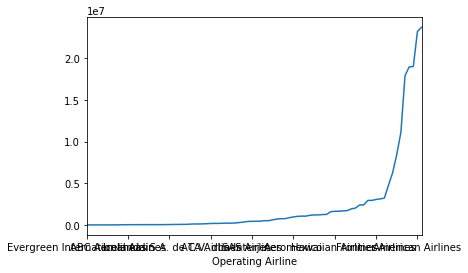

In [36]:
# Cutoff seems to be around 250,000 total passengers, for major airlines
total_enplaned[:-1].plot();

In [37]:
# Can see the most important airways
list(zip(total_enplaned.index, list(total_enplaned)))

[('Evergreen International Airlines', 2),
 ('Ameriflight', 72),
 ('Xtra Airways', 73),
 ('Norwegian Air UK Ltd', 330),
 ('World Airways', 530),
 ('Miami Air International', 733),
 ('Air Canada Jazz', 1985),
 ('BelAir Airlines', 4821),
 ('Allegiant Air', 12090),
 ('Atlantic Southeast Airlines', 25641),
 ('Icelandair', 26860),
 ('Iberia', 28392),
 ('Finnair', 28866),
 ('Republic Airlines', 29726),
 ('Thomas Cook Airlines', 31573),
 ('Icelandair EHF', 31679),
 ('Jet Airways', 32077),
 ('French Bee', 32277),
 ('Independence Air', 32556),
 ('Spirit Airlines', 37172),
 ('ABC Aerolineas S.A. de C.V. dba Interjet', 44184),
 ('Air Pacific Limited dba Fiji Airways', 53146),
 ('Hong Kong Airlines Limited', 55994),
 ('Mesaba Airlines', 63428),
 ('XL Airways France', 67001),
 ('ExpressJet Airlines', 93456),
 ('Volaris Airlines', 113438),
 ('Air Berlin', 113644),
 ('LAN Peru', 125095),
 ('Jazz Aviation', 142716),
 ('ATA Airlines', 175794),
 ('WOW Air', 179677),
 ('Etihad Airways', 182806),
 ('Americ

In [38]:
# Finds the names of the top 15 airlines by quantity of passengers leaving SFO

top15_list = list(df_grouped.groupby('Operating Airline').
                  sum().
                  sort_values('Passenger Count Enplaned', ascending = False)[:15].
                  index)

In [39]:
top15_list

['United Airlines',
 'SkyWest Airlines',
 'American Airlines',
 'Virgin America',
 'Delta Air Lines',
 'Southwest Airlines',
 'Alaska Airlines',
 'US Airways',
 'JetBlue Airways',
 'Air Canada',
 'Lufthansa German Airlines',
 'Northwest Airlines',
 'Frontier Airlines',
 'Cathay Pacific',
 'British Airways']

# Time Series (full airport's arrivals)

In [40]:
dp_airport = df_deplaned.groupby('date').sum()

### Train/Test Split

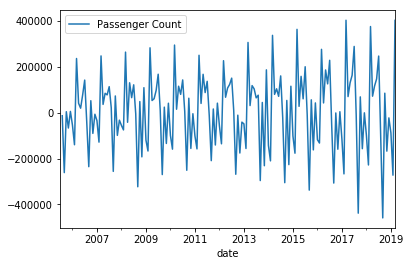

In [41]:
dp_airport.diff().plot();

In [42]:
# Taking the log of the train data for training the model on multiplicative data
train = dp_airport.loc[dp_airport.index.year <= 2014, 'Passenger Count']
test = dp_airport.loc[dp_airport.index.year >= 2015, 'Passenger Count']

### Data Visualization, pre-SARIMA

In [43]:
# 1 diff seems to work really well for this data
dp_airport.diff()['Passenger Count'].autocorr()

-0.07974577331389328

In [44]:
# define helper plot function for visualization
# Needs to be fixed so that data.plot either works (damaged by FB Prophet import)
def make_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    #plt.plot(data,ax=raw,figsize=(12,6))
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

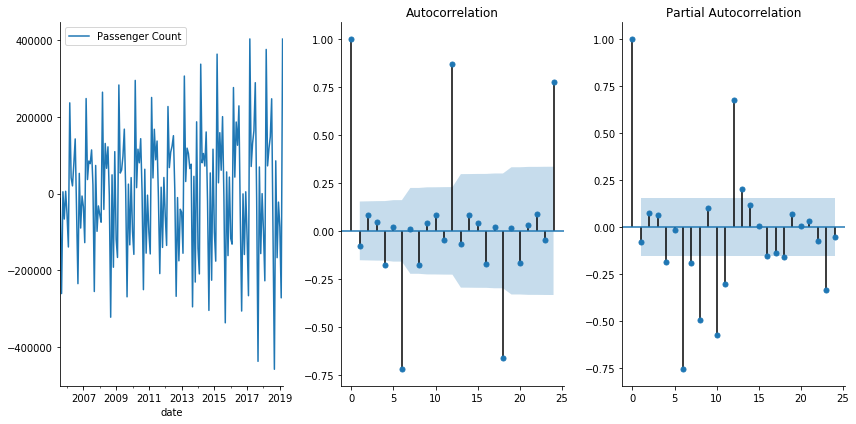

In [45]:
# ACF and PACF make_plots look the same from all different starting point months
plt.figure(figsize = (15,8))
make_plots(dp_airport.diff()[1:], lags=24);

## Build SARIMA pipeline

In [47]:
sar = SARIMAX(train, order=(1,0,2), seasonal_order=(0,1,2,12), trend='t',
              enforce_stationarity=False, enforce_invertibility=False).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


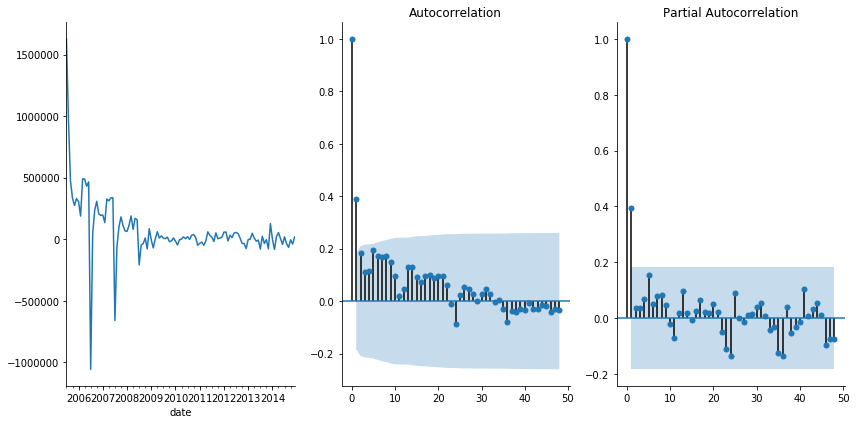

In [48]:
make_plots(sar.resid, lags = 48)


### The above plot shows that we can still get predictive power out of the first order ACF and PACF

### Below - a new model defined with a second order of differencing

First, I'm going to have only a train/test split, with a large test set (let's say 4 years, so I can predict SFO's capacity needs 4 years into the future).

Instead of testing my model's performance on predicting validation data, I'm going to pick the model with the lowest AIC (chooses the best model based on a combination of how well the model fits the data (with log-likelihood), penalized for model complexity via its degrees of freedom).

Then, once I have the model with the lowest AIC, I'm going to use that model to predict my test set. (https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict.html)

Once I have my predictions, I'll calculate the residuals of the predictions, divided by the true values. **(Note: I should only be scoring the performance of my model on predictions it makes starting 2 years after it sees data, since the ideal model deals with 2 previous periods on a 12 month lag)** This will give me a good measure of how much error to expect in my capacity planning (Ex: 5%). Useful for presentation purposes on what to expect from the model.

Then I will retrain my model with the most recent data, and attempt to predict the values for 2019-23. The expected error is the same as what we had from my residuals in my 2015-19 prediction.

## Note: This cell had trend of "t" instead of "n"

In [72]:
best_sarima = SARIMAX(train, order=(1,1,2), seasonal_order=(0,1,2,12), trend='t',
                      enforce_stationarity=False, enforce_invertibility=False).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


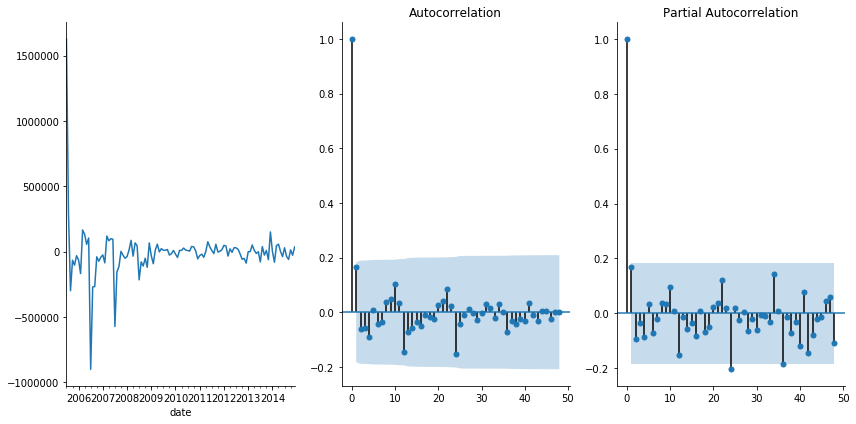

In [73]:
# Should show ACF and PACF plot - look at make_plots to fix broken function due to FB Prophet
make_plots(best_sarima.resid, lags = 48)

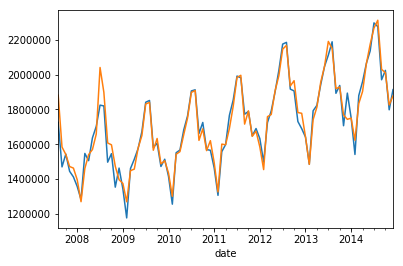

In [74]:
# Model predictions start 2 years out, since model incorporates 2 MA elements of 12 month seasons
#plt.figure(figsize=(15,8))
train[25:].plot()
best_sarima.predict(start = 25).plot();

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



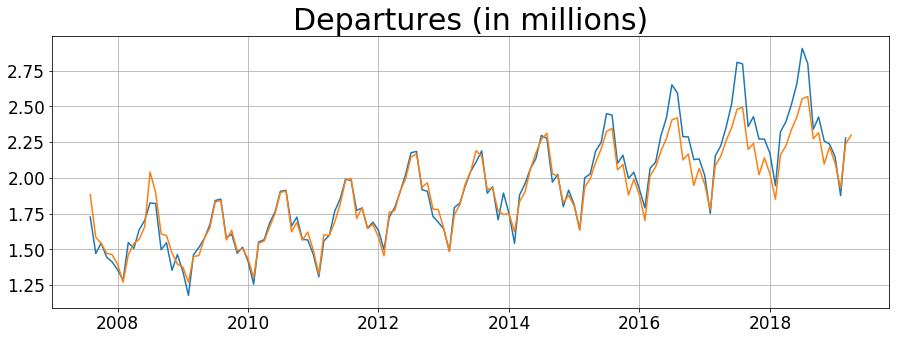

In [166]:
plt.figure(figsize=(15,5))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport[25:] / 1000000)
plt.plot(best_sarima.predict(start=25, end=len(train)+len(test)) / 1000000)
plt.savefig('img/sarima_fit.png', bbox_inches = 'tight');

In [54]:
# Starts prediction at the end of train data, through the full dataset (train + test)
test_prediction = best_sarima.predict(start=len(train), end=(len(train)+len(test)))

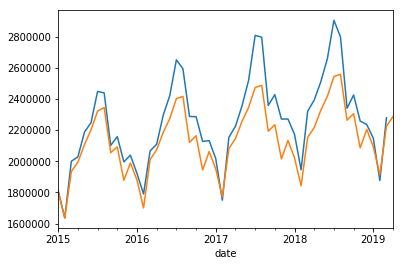

In [75]:
#plt.figure(figsize=(12,7))
test.plot()
test_prediction.plot()
plt.savefig('img/test_prediction.png', bbox_inches = 'tight');

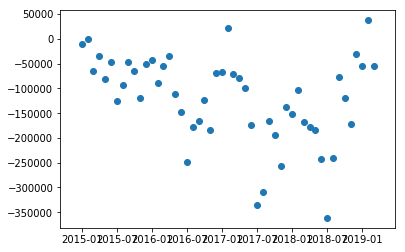

In [56]:
arima_residuals = test_prediction - test
plt.scatter(test_prediction.index, arima_residuals);

In [57]:
test_prediction

2015-01-01    1.803149e+06
2015-02-01    1.636059e+06
2015-03-01    1.934257e+06
2015-04-01    1.993630e+06
2015-05-01    2.106614e+06
2015-06-01    2.201582e+06
2015-07-01    2.322392e+06
2015-08-01    2.344911e+06
2015-09-01    2.055306e+06
2015-10-01    2.092478e+06
                  ...     
2018-07-01    2.544111e+06
2018-08-01    2.558718e+06
2018-09-01    2.263643e+06
2018-10-01    2.305828e+06
2018-11-01    2.085821e+06
2018-12-01    2.204477e+06
2019-01-01    2.092471e+06
2019-02-01    1.913539e+06
2019-03-01    2.223897e+06
2019-04-01    2.287272e+06
Freq: MS, Length: 52, dtype: float64

In [58]:
def mae_residuals(start, end, test):
    '''
    Finds residuals based on "best_sarima" model, and the end point defined relative to the training data
    '''
    test_predictions = best_sarima.predict(start=len(train)+start, end=len(train)+end)
    residuals = test_predictions - test
    answer = abs(residuals).sum() / test[start:end].sum() * 100 # Calculate residual MAE for the proper slice of time
    return answer

In [59]:
# My predictions can be overall expected to be ~5.25% off from the actual values
abs(arima_residuals).sum() / test.sum() * 100

5.449889786955952

***My ARIMA predictions can be expected to be ~5.25% off from the actual values - projection below***

In [60]:
# MAE by year, to show increasing error over time for model's predictions
print(mae_residuals(0,12, test))
print(mae_residuals(12, 24, test))
print(mae_residuals(24, 36, test))
print(mae_residuals(36, 48, test))

print(mae_residuals(0,48, test)) # Overall residuals

3.1022431222333577
5.6779852652837155
7.367574039002219
7.183163035856962
5.680569928636803


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


***The above are the errors that I can expect for every year of subsequent predictions***

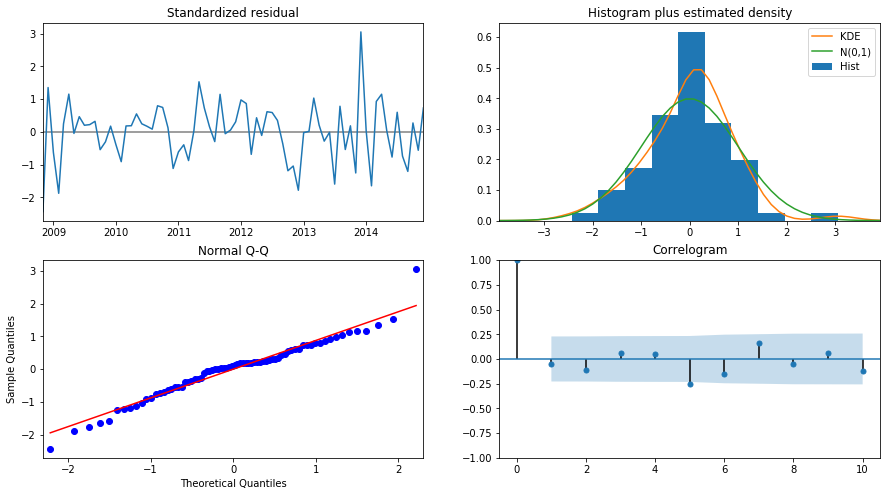

In [61]:
best_sarima.plot_diagnostics(figsize = (15,8));
plt.savefig('img/sarima_diagnostics.png', bbox_inches = 'tight')

In [62]:
test_sarima = SARIMAX(train, order=(1,1,2), seasonal_order=(0,1,2,12), trend='t',
                       enforce_stationarity=False, enforce_invertibility=False).fit()

test_sarima_prediction = test_sarima.predict(start=len(train), end=len(train)+96)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


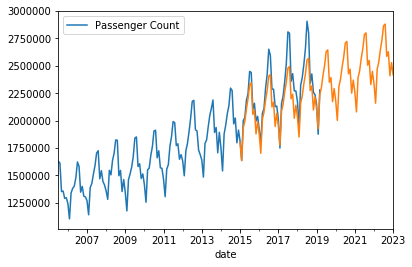

In [63]:
dp_airport.plot()
test_sarima_prediction.plot()

# Final SARIMA

In [80]:
# NOTE: This final_sarima is tweaked from the ideal one above, because the ARIMA was projecting a declining
# SFO attendance, probably due to the two most recent years of data that it erroneously extrapolates from
final_sarima = SARIMAX(dp_airport, order=(1,1,2), seasonal_order=(1,1,2,12), trend='n',
                       enforce_stationarity=False, enforce_invertibility=False).fit()

final_sarima_prediction = final_sarima.predict(start=len(dp_airport), end=len(dp_airport)+48)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


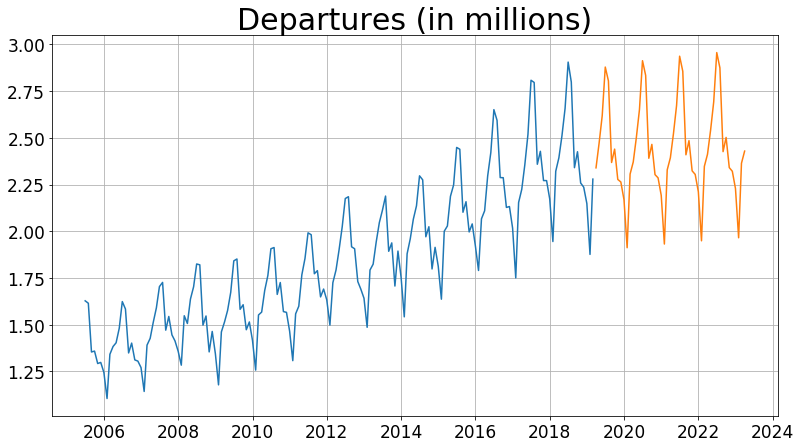

In [168]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(final_sarima_prediction.index, final_sarima_prediction / 1000000)
plt.savefig('img/sarima_projection.png', bbox_inches = 'tight');

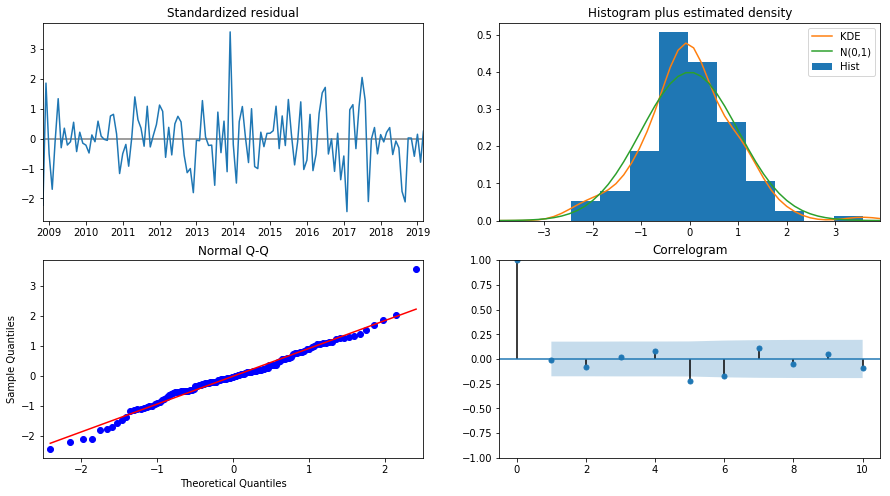

In [171]:
# This is the final diagnostic plot of my best SARIMA
final_sarima.plot_diagnostics(figsize = (15,8))
plt.savefig('img/sarima_assumptions.png', bbox_inches = 'tight');

In [67]:
print(np.max(final_sarima_prediction) -  np.max(dp_airport)) # Difference in 
print(np.max(final_sarima_prediction) / np.max(dp_airport))

np.set_printoptions(suppress=True)
print(final_sarima_prediction[-12:].sum() / dp_airport[-12:].sum()) # Percentage traffic growth after 4 years
print((final_sarima_prediction[-12:].sum() - dp_airport[-12:].sum()) / 4) # Avg traffic growth each year

Passenger Count    56906.390986
dtype: float64
Passenger Count    1.019585
dtype: float64
Passenger Count    1.03145
dtype: float64
Passenger Count    226667.82414
dtype: float64


**My SARIMA model predicts almost no growth in passenger count - only 2% growth in 4 years. My SARIMA model takes the last 2 year's leveling off of the trend very seriously**

# Facebook Prophet

## **Room for improvement - include cross-validation over time with FBProphet**
https://facebook.github.io/prophet/docs/diagnostics.html

In [85]:
from fbprophet import Prophet

In [151]:
# Setting up data in proper format for Prophet - and dividing into millions
fb_train = (train / 1000000).reset_index()
fb_train.columns = ['ds','y']

In [152]:
fb_model = Prophet(seasonality_mode='multiplicative')
fb_model.fit(fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [153]:
fb_test = test.reset_index()
fb_test.columns = ['ds','y']

In [154]:
forecast = fb_model.predict(fb_test)

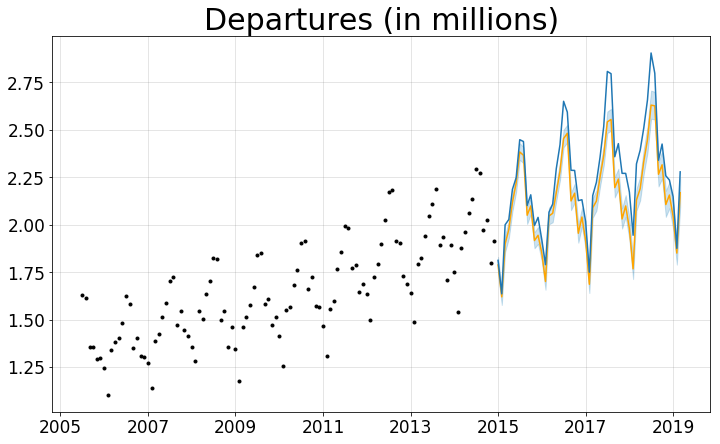

In [170]:
# Plot of FBProphet performance (multiplicative) vs the test set
fb_model.plot(forecast)
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.set_yticklabels(labels = [1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0])
plt.grid(b=True)
plt.gca().get_lines()[1].set_color("orange")
plt.plot(test.index, test / 1000000)
plt.savefig('img/fb_fit.png', bbox_inches = 'tight');

In [309]:
test / 1000000

date
2015-01-01    1.812521
2015-02-01    1.636133
2015-03-01    1.999996
2015-04-01    2.028066
2015-05-01    2.186927
2015-06-01    2.247789
2015-07-01    2.448567
2015-08-01    2.438908
2015-09-01    2.101544
2015-10-01    2.158013
                ...   
2018-06-01    2.658235
2018-07-01    2.905562
2018-08-01    2.798782
2018-09-01    2.340188
2018-10-01    2.425591
2018-11-01    2.258229
2018-12-01    2.235904
2019-01-01    2.148066
2019-02-01    1.875859
2019-03-01    2.278985
Name: Passenger Count, Length: 51, dtype: float64

In [310]:
fb_pred = forecast['yhat'] # Separating the prediction
fb_pred.index = test.index # Allowing them to be subtracted with the same index
fb_mae = np.mean(abs(fb_pred - (test / 1000000)) / (test / 1000000))

In [311]:
fb_mae

0.051888664008829896

**FB Prophet's model is only *slightly* better than SARIMA - at 5.4% MAE rather than SARIMA's 5.5%**

### Interpretation:

Since my data is a fairly straightforward time series without much outside data, it is performing in SARIMA's strong point, without using the advantages of more sophisticated models. I can expect that the LSTM will have a similar performance, since it may be an actual anomaly in growth at SFO that contributed to the 5.5% MAE from prediction to actual values

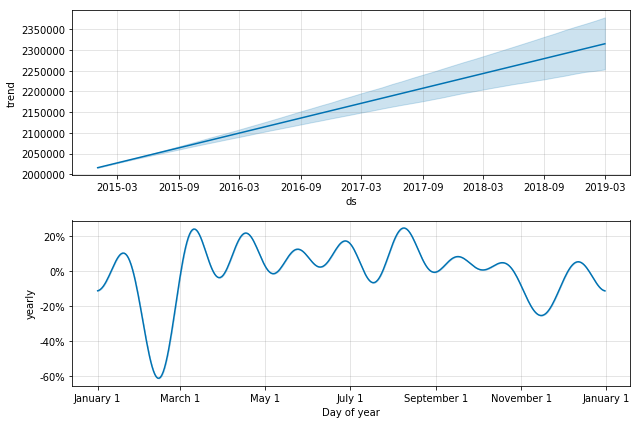

In [128]:
fb_model.plot_components(forecast);

In [163]:
fb_dp_airport = (dp_airport / 1000000).reset_index()
fb_dp_airport.columns = ['ds','y']

In [164]:
# Final FB Prophet model to predict 4 years into the future
fb_model_final = Prophet(seasonality_mode='multiplicative').fit(fb_dp_airport)

future = fb_model_final.make_future_dataframe(periods=48, freq='M') # Making new rows for future
future[-48:] += pd.DateOffset(1) # +1 on dates to change from 3/31 to 4/01, for example. Uniform w/ previous data

fb_future_pred = fb_model_final.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



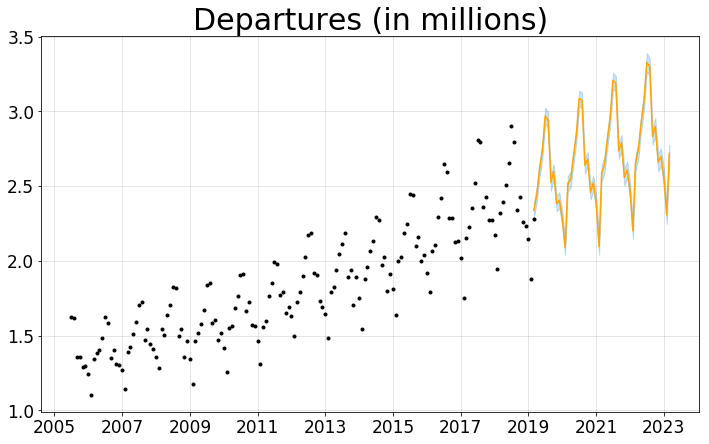

In [172]:
# Plotting predictions into the future
fb_model_final.plot(fb_future_pred[-49:])
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.gca().get_lines()[1].set_color("orange")
plt.savefig('img/fb_projection.png', bbox_inches = 'tight');

In [132]:
# Predicted needed max capacity of SFO in the year 2023
print(np.max(fb_future_pred['yhat']))
print(np.max(test))

print(fb_future_pred['yhat'][-12:].sum() / dp_airport[-12:].sum()) # Percentage traffic growth after 4 years
print((fb_future_pred['yhat'][-12:].sum() - dp_airport[-12:].sum()) / 4) # Avg traffic growth each year

3328375.1057612374
2905562
Passenger Count    1.181025
dtype: float64
Passenger Count    1.304686e+06
dtype: float64


# LSTM

Looking to exceed the performance of my SARIMA and FB Prophet models in predicting the test set, after training on the train set

In [177]:
# Starting the training data at the beginning of the year
lstm_train = train[6:]

In [180]:
# Data preprocessing in order to get rows of 12 months as x, and the result as y
# Credit to Jason Brownlee: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [220]:
X, y = split_sequence(lstm_train, 12)

X = X.reshape((96,12,1)) # Adding an artificial third dimension to fit into my LSTM model

In [233]:
lstm = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
lstm.add(LSTM(64, activation='relu', input_shape=(12,1)))
#lstm.add(LSTM(32, activation='relu', input_shape=(32,1)))
lstm.add(Dense(10))
lstm.add(Dropout(0.3))
#lstm.add(Dense(10))
#lstm.add(Dropout(0.3))
lstm.add(Dense(1))


lstm.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
lstm.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=32, epochs=100)
# Batch size of 8 or 16 - increments of 2^x

# Specify batch size when I fit model - larger is more accurate but slower

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 6s 66ms/step - loss: 2018277.2500 - val_loss: 2193961.0000
Epoch 2/100
96/96 [==============================] - 0s 451us/step - loss: 1820761.5417 - val_loss: 1966033.3750
Epoch 3/100
96/96 [==============================] - 0s 469us/step - loss: 1693704.6250 - val_loss: 1796557.6250
Epoch 4/100
96/96 [==============================] - 0s 509us/step - loss: 1574939.7083 - val_loss: 1584401.8750
Epoch 5/100
96/96 [==============================] - 0s 433us/step - loss: 1390240.2500 - val_loss: 1362571.5000
Epoch 6/100
96/96 [==============================] - 0s 469us/step - loss: 1169014.5417 - val_loss: 1223889.7500
Epoch 7/100
96/96 [==============================] - 0s 585us/step - loss: 1068950.8958 - val_loss: 1140845.0000
Epoch 8/100
96/96 [==============================] - 0s 627us/step - loss: 940675.8333 - val_loss: 915901.5000
Epoch 9/100
96/96 [==============================] - 0s

96/96 [==============================] - 0s 695us/step - loss: 458173.7188 - val_loss: 239141.0781
Epoch 74/100
96/96 [==============================] - 0s 556us/step - loss: 382263.3333 - val_loss: 170771.9844
Epoch 75/100
96/96 [==============================] - 0s 556us/step - loss: 389196.7292 - val_loss: 176268.7656
Epoch 76/100
96/96 [==============================] - 0s 555us/step - loss: 347951.0625 - val_loss: 170520.2344
Epoch 77/100
96/96 [==============================] - 0s 610us/step - loss: 374647.8750 - val_loss: 185491.2656
Epoch 78/100
96/96 [==============================] - 0s 559us/step - loss: 381771.0729 - val_loss: 175133.3750
Epoch 79/100
96/96 [==============================] - 0s 580us/step - loss: 419839.2083 - val_loss: 165769.6719
Epoch 80/100
96/96 [==============================] - 0s 646us/step - loss: 359059.9167 - val_loss: 177294.6250
Epoch 81/100
96/96 [==============================] - 0s 674us/step - loss: 371575.0938 - val_loss: 219009.7656
Epoch

In [200]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 12, 64)            16896     
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 29,653
Trainable params: 29,653
Non-trainable params: 0
_________________________________________________________________


# CNN - LSTM

In [226]:
# Testing out CNN-LSTMs

n_features = 1
# Splitting it into seasons - to see if there are patterns
n_seq = 4
# Considering 1 year's worth of data. Should experiment with 24 months - based on SARIMA
n_steps = 3
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
# fit model
model.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=16, epochs=100)
# demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)



Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 5s 55ms/step - loss: 1687310.1667 - val_loss: 1801844.5000
Epoch 2/100
96/96 [==============================] - 0s 545us/step - loss: 1524957.0208 - val_loss: 1624995.5417
Epoch 3/100
96/96 [==============================] - 0s 689us/step - loss: 1380879.7292 - val_loss: 1483435.1667
Epoch 4/100
96/96 [==============================] - 0s 636us/step - loss: 1252301.1875 - val_loss: 1315526.0417
Epoch 5/100
96/96 [==============================] - 0s 678us/step - loss: 1094977.1667 - val_loss: 1120975.5000
Epoch 6/100
96/96 [==============================] - 0s 517us/step - loss: 915003.0729 - val_loss: 913295.2500
Epoch 7/100
96/96 [==============================] - 0s 665us/step - loss: 749937.0521 - val_loss: 759239.7500
Epoch 8/100
96/96 [==============================] - 0s 596us/step - loss: 628069.4479 - val_loss: 624286.0417
Epoch 9/100
96/96 [==============================] - 0s 830

Epoch 74/100
96/96 [==============================] - 0s 589us/step - loss: 140964.0391 - val_loss: 148428.8333
Epoch 75/100
96/96 [==============================] - 0s 820us/step - loss: 141032.4453 - val_loss: 148452.4010
Epoch 76/100
96/96 [==============================] - 0s 788us/step - loss: 140927.2721 - val_loss: 148378.8490
Epoch 77/100
96/96 [==============================] - 0s 829us/step - loss: 140887.6771 - val_loss: 148343.1875
Epoch 78/100
96/96 [==============================] - 0s 575us/step - loss: 140934.6120 - val_loss: 148328.5833
Epoch 79/100
96/96 [==============================] - 0s 565us/step - loss: 140988.0430 - val_loss: 148528.5469
Epoch 80/100
96/96 [==============================] - 0s 612us/step - loss: 140865.3984 - val_loss: 148380.5365
Epoch 81/100
96/96 [==============================] - 0s 568us/step - loss: 140880.7630 - val_loss: 148595.5938
Epoch 82/100
96/96 [==============================] - 0s 580us/step - loss: 140662.9596 - val_loss: 1482

In [242]:
cnn_lstm_test = np.array(test).reshape(1, n_seq, n_steps, n_features)
model.predict(cnn_lstm_test)

ValueError: cannot reshape array of size 51 into shape (1,4,3,1)

# GRU (trained on train data)

In [323]:
X, y = split_sequence(lstm_train, 12)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [709]:
gru = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru.add(GRU(128, activation='relu', input_shape=(32,1)))
gru.add(Dense(64))
# gru.add(Dropout(0.08))
gru.add(Dense(32))
gru.add(Dense(16))
# gru.add(Dropout(0.08))
gru.add(Dense(1))


gru.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru.fit(X, y, validation_data=(X[-24:],y[-24:]), shuffle=False, batch_size=32, epochs=500)
# Batch size of 8 or 16 - increments of 2^x

Train on 96 samples, validate on 24 samples
Epoch 1/500
96/96 [==============================] - 11s 112ms/step - loss: 1474566.1667 - val_loss: 1360361.3750
Epoch 2/500
96/96 [==============================] - 0s 943us/step - loss: 1024091.5208 - val_loss: 740948.5000
Epoch 3/500
96/96 [==============================] - 0s 1ms/step - loss: 436660.6042 - val_loss: 138469.4844
Epoch 4/500
96/96 [==============================] - 0s 1ms/step - loss: 218019.0208 - val_loss: 403512.5000
Epoch 5/500
96/96 [==============================] - 0s 2ms/step - loss: 311668.9583 - val_loss: 217467.9531
Epoch 6/500
96/96 [==============================] - 0s 1ms/step - loss: 145223.0365 - val_loss: 158795.0781
Epoch 7/500
96/96 [==============================] - 0s 1ms/step - loss: 167880.3125 - val_loss: 227216.0469
Epoch 8/500
96/96 [==============================] - 0s 1ms/step - loss: 193250.0260 - val_loss: 175728.1719
Epoch 9/500
96/96 [==============================] - 0s 1ms/step - loss: 130

Epoch 76/500
96/96 [==============================] - 0s 1ms/step - loss: 54475.8320 - val_loss: 63276.8906
Epoch 77/500
96/96 [==============================] - 0s 1ms/step - loss: 57307.4310 - val_loss: 78257.4453
Epoch 78/500
96/96 [==============================] - 0s 1ms/step - loss: 53942.4531 - val_loss: 62042.5625
Epoch 79/500
96/96 [==============================] - 0s 1ms/step - loss: 56592.7031 - val_loss: 71940.5859
Epoch 80/500
96/96 [==============================] - 0s 1ms/step - loss: 53762.2904 - val_loss: 61034.1875
Epoch 81/500
96/96 [==============================] - 0s 1ms/step - loss: 56956.7161 - val_loss: 83555.3828
Epoch 82/500
96/96 [==============================] - 0s 1ms/step - loss: 55046.9310 - val_loss: 68278.1719
Epoch 83/500
96/96 [==============================] - 0s 1ms/step - loss: 66308.8294 - val_loss: 99846.4609
Epoch 84/500
96/96 [==============================] - 0s 1ms/step - loss: 58017.7461 - val_loss: 69198.9844
Epoch 85/500
96/96 [========

96/96 [==============================] - 0s 1ms/step - loss: 52955.6992 - val_loss: 54584.6719
Epoch 152/500
96/96 [==============================] - 0s 1ms/step - loss: 59024.3477 - val_loss: 68226.2422
Epoch 153/500
96/96 [==============================] - 0s 1ms/step - loss: 56196.7135 - val_loss: 56417.0273
Epoch 154/500
96/96 [==============================] - 0s 1ms/step - loss: 54399.5977 - val_loss: 60317.2539
Epoch 155/500
96/96 [==============================] - 0s 1ms/step - loss: 50462.6914 - val_loss: 56508.8867
Epoch 156/500
96/96 [==============================] - 0s 1ms/step - loss: 51277.3151 - val_loss: 64653.1055
Epoch 157/500
96/96 [==============================] - 0s 1ms/step - loss: 49474.4792 - val_loss: 54119.9570
Epoch 158/500
96/96 [==============================] - 0s 1ms/step - loss: 54505.0143 - val_loss: 70811.7656
Epoch 159/500
96/96 [==============================] - 0s 1ms/step - loss: 51578.0182 - val_loss: 54018.2969
Epoch 160/500
96/96 [============

96/96 [==============================] - 0s 1ms/step - loss: 56940.7070 - val_loss: 69163.1094
Epoch 227/500
96/96 [==============================] - 0s 1ms/step - loss: 55541.9922 - val_loss: 55597.3008
Epoch 228/500
96/96 [==============================] - 0s 1ms/step - loss: 53995.1810 - val_loss: 62034.3086
Epoch 229/500
96/96 [==============================] - 0s 1ms/step - loss: 51326.0117 - val_loss: 54549.0820
Epoch 230/500
96/96 [==============================] - 0s 1ms/step - loss: 52723.6784 - val_loss: 67758.6953
Epoch 231/500
96/96 [==============================] - 0s 1ms/step - loss: 53796.1927 - val_loss: 53963.3906
Epoch 232/500
96/96 [==============================] - 0s 1ms/step - loss: 54600.3958 - val_loss: 63378.3242
Epoch 233/500
96/96 [==============================] - 0s 1ms/step - loss: 51321.7500 - val_loss: 53606.4883
Epoch 234/500
96/96 [==============================] - 0s 1ms/step - loss: 55067.9609 - val_loss: 69607.1641
Epoch 235/500
96/96 [============

96/96 [==============================] - 0s 1ms/step - loss: 50406.1237 - val_loss: 53764.4102
Epoch 302/500
96/96 [==============================] - 0s 1ms/step - loss: 52280.6732 - val_loss: 69117.7266
Epoch 303/500
96/96 [==============================] - 0s 1ms/step - loss: 52647.8516 - val_loss: 53468.3398
Epoch 304/500
96/96 [==============================] - 0s 1ms/step - loss: 55058.7344 - val_loss: 67260.9297
Epoch 305/500
96/96 [==============================] - 0s 1ms/step - loss: 54208.1302 - val_loss: 55208.3594
Epoch 306/500
96/96 [==============================] - 0s 1ms/step - loss: 52198.0690 - val_loss: 63863.2930
Epoch 307/500
96/96 [==============================] - 0s 1ms/step - loss: 51220.7734 - val_loss: 53605.7344
Epoch 308/500
96/96 [==============================] - 0s 1ms/step - loss: 53567.4727 - val_loss: 65205.5977
Epoch 309/500
96/96 [==============================] - 0s 1ms/step - loss: 51624.4974 - val_loss: 53599.3125
Epoch 310/500
96/96 [============

96/96 [==============================] - 0s 1ms/step - loss: 54898.2331 - val_loss: 66724.6328
Epoch 377/500
96/96 [==============================] - 0s 1ms/step - loss: 53331.7383 - val_loss: 54064.7695
Epoch 378/500
96/96 [==============================] - 0s 1ms/step - loss: 52273.8008 - val_loss: 63465.2227
Epoch 379/500
96/96 [==============================] - 0s 1ms/step - loss: 51301.7565 - val_loss: 53925.6211
Epoch 380/500
96/96 [==============================] - 0s 1ms/step - loss: 51845.7552 - val_loss: 64591.1836
Epoch 381/500
96/96 [==============================] - 0s 1ms/step - loss: 50821.6758 - val_loss: 53281.3750
Epoch 382/500
96/96 [==============================] - 0s 1ms/step - loss: 52621.9245 - val_loss: 63809.0273
Epoch 383/500
96/96 [==============================] - 0s 996us/step - loss: 50749.1081 - val_loss: 53333.6211
Epoch 384/500
96/96 [==============================] - 0s 1ms/step - loss: 52807.1784 - val_loss: 65694.5859
Epoch 385/500
96/96 [==========

96/96 [==============================] - 0s 1ms/step - loss: 48991.4596 - val_loss: 55920.0312
Epoch 452/500
96/96 [==============================] - 0s 1ms/step - loss: 47941.4948 - val_loss: 55309.3086
Epoch 453/500
96/96 [==============================] - 0s 1ms/step - loss: 47809.2943 - val_loss: 54312.5664
Epoch 454/500
96/96 [==============================] - 0s 1ms/step - loss: 48654.2578 - val_loss: 60680.2188
Epoch 455/500
96/96 [==============================] - 0s 1ms/step - loss: 47876.5078 - val_loss: 53135.4414
Epoch 456/500
96/96 [==============================] - 0s 1ms/step - loss: 51338.2227 - val_loss: 68360.8516
Epoch 457/500
96/96 [==============================] - 0s 1ms/step - loss: 50457.5586 - val_loss: 52218.2930
Epoch 458/500
96/96 [==============================] - 0s 1ms/step - loss: 55801.4362 - val_loss: 69474.1406
Epoch 459/500
96/96 [==============================] - 0s 1ms/step - loss: 54723.3229 - val_loss: 53710.5195
Epoch 460/500
96/96 [============

In [532]:
test_X, test_y = split_sequence(test, 12)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

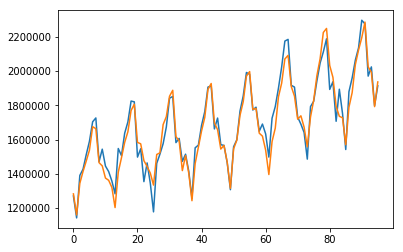

In [597]:
# Shows how well the model fits the train data
gru_train_pred = gru.predict(X)

plt.plot(y)
plt.plot(gru_train_pred);

##  vvv Old prediction that may be wrong based on my analysis

In [660]:
gru_test_pred = np.append(gru_start_test_pred, gru_test_pred, axis=0)

In [661]:
gru_test_pred

array([[1727040.6],
       [1569384.9],
       [1788541.6],
       [1873691.9],
       [2037489. ],
       [2122911.2],
       [2194665. ],
       [2285751.5],
       [2024526.8],
       [1992368.1],
       [1791975.1],
       [1936246.5],
       [1893198.8],
       [1720732.5],
       [2013972.6],
       [2084161. ],
       [2266730.5],
       [2331081.5],
       [2536545.5],
       [2568375. ],
       [2260752. ],
       [2229127.5],
       [2078851.4],
       [2106503.5],
       [1998997.1],
       [1868620.5],
       [2062203.8],
       [2160774.5],
       [2390710. ],
       [2490242.5],
       [2714905.2],
       [2732352. ],
       [2464253.5],
       [2351731.2],
       [2209154. ],
       [2211576.2],
       [2105616.2],
       [1860365.5],
       [2172188.5],
       [2295323.5],
       [2472698. ],
       [2604549.5],
       [2873081.5],
       [2917623.8],
       [2512321.5],
       [2469109.5],
       [2324174. ],
       [2339932.5],
       [2231764.5],
       [2027137.4],


## ^^^ Old prediction that may be wrong based on my analysis

In [546]:
# Feeding the last 12 months of test to my GRU now that it's been trained. My model will predict 4 years' future

def rolling_predict(starting_data, keras_model, window_size, n_months_to_predict):
    '''
    starting_data = Starting x_month length seed to predict the next value (Ex: 12 vals to predict 13th)
    
    Make a rolling window prediction such that my neural nets can predict future times off their past predictions
    '''
    
    # Seed the start of the rolling window
    rolling_window = starting_data[-window_size:].reshape(1,window_size,1)
    
    model_predictions = []
    
    for i in range(n_months_to_predict): # Predicting 4 years
        # Predicting off of the last n number of predictions according to window size, indexing the array
        next_pred = keras_model.predict(rolling_window[:,-window_size:,:])
        # Pulling the next_pred out of its 1x1 matrix to put into its own list
        model_predictions.append(next_pred[0,0])
        # Moving rolling window in the proper dimension of the 3D array needed for keras (2nd dimension)
        rolling_window = np.append(rolling_window, next_pred.reshape(1,1,1), axis=1)
        
    return model_predictions

In [705]:
gru_test_predictions = rolling_predict(y[-12:], gru, 12, 51)

In [706]:
# Assigning dates to gru_test_pred to allow it to be plotted
gru_test_predictions = pd.DataFrame(gru_test_predictions)
gru_test_predictions.index = dp_airport[-51:].index

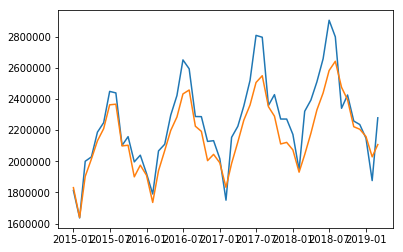

In [707]:
plt.plot(test)
plt.plot(gru_test_predictions);

In [708]:
# MAE is 5.7%
np.mean(abs(gru_test_predictions.iloc[:,0] - test) / test)

0.04557168964591366

In [613]:
# Assigning dates to gru_test_pred to allow it to be plotted
gru_test_pred = pd.DataFrame(gru_test_pred)
gru_test_pred.index = dp_airport[-39:].index

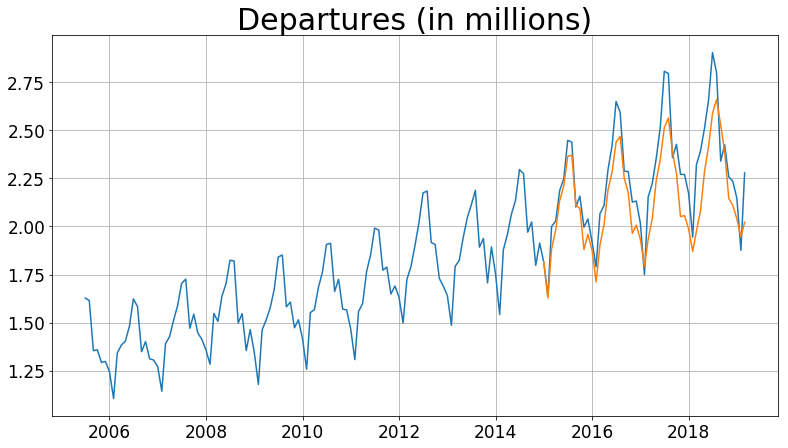

In [699]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport['Passenger Count'] / 1000000)
plt.plot(gru_test_predictions.index, gru_test_predictions / 1000000);

In [701]:
gru_predictions = rolling_predict(test_y, gru, 12, 48)

In [549]:
# Setting it in a format that is able to be graphed
future = future[-48:]
future['Predictions'] = gru_predictions

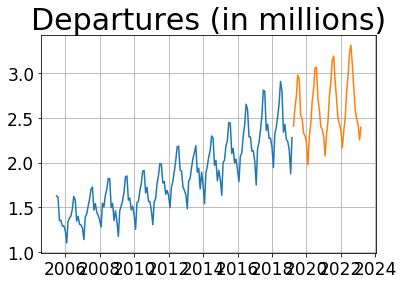

In [591]:
# Graphing my GRU neural net
# plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions'] / 1000000);

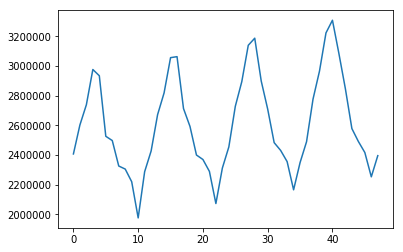

In [548]:
plt.plot(gru_predictions)

# GRU 2 (trained on dp_airport)

Refitting the GRU on all the data from dp_airport, so that my neural net follows the same model as the previous models (train, use test to estimate MAE, and then retrain on all data to predict final values). Unclear whether this model is best at predicting, since it gives the most extreme capacity prediction.

In [562]:
gru2_X, gru2_y = split_sequence(dp_airport['Passenger Count'], 12)
gru2_X = gru2_X.reshape(gru2_X.shape[0], gru2_X.shape[1], 1)

In [563]:
gru2 = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru2.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru2.add(GRU(128, activation='relu', input_shape=(32,1)))
gru2.add(Dense(64))
# gru2.add(Dropout(0.08))
gru2.add(Dense(32))
gru2.add(Dense(16))
# gru2.add(Dropout(0.08))
gru2.add(Dense(1))


gru2.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru2.fit(gru2_X, gru2_y, validation_data=(gru2_X[-24:],gru2_y[-24:]), shuffle=False, batch_size=16, epochs=300)

Train on 153 samples, validate on 24 samples
Epoch 1/300
153/153 [==============================] - 11s 72ms/step - loss: 1706956.8873 - val_loss: 1737809.7083
Epoch 2/300
153/153 [==============================] - 0s 2ms/step - loss: 782517.1908 - val_loss: 201999.8542
Epoch 3/300
153/153 [==============================] - 0s 2ms/step - loss: 258796.8609 - val_loss: 259965.7188
Epoch 4/300
153/153 [==============================] - 0s 2ms/step - loss: 182513.3808 - val_loss: 221864.0417
Epoch 5/300
153/153 [==============================] - 0s 2ms/step - loss: 133769.9340 - val_loss: 168843.5677
Epoch 6/300
153/153 [==============================] - 0s 2ms/step - loss: 125412.9474 - val_loss: 153376.6979
Epoch 7/300
153/153 [==============================] - 0s 2ms/step - loss: 139953.1879 - val_loss: 199880.8958
Epoch 8/300
153/153 [==============================] - 0s 2ms/step - loss: 160127.4105 - val_loss: 191370.1042
Epoch 9/300
153/153 [==============================] - 0s 2ms/s

153/153 [==============================] - 0s 2ms/step - loss: 63025.3902 - val_loss: 76384.4427
Epoch 75/300
153/153 [==============================] - 0s 2ms/step - loss: 65447.2977 - val_loss: 78428.2917
Epoch 76/300
153/153 [==============================] - 0s 2ms/step - loss: 77082.2937 - val_loss: 74847.5208
Epoch 77/300
153/153 [==============================] - 0s 2ms/step - loss: 68886.6580 - val_loss: 75179.6719
Epoch 78/300
153/153 [==============================] - 0s 2ms/step - loss: 65230.7161 - val_loss: 76774.8594
Epoch 79/300
153/153 [==============================] - 0s 2ms/step - loss: 71304.4590 - val_loss: 75192.2500
Epoch 80/300
153/153 [==============================] - 0s 2ms/step - loss: 66803.3395 - val_loss: 75767.6458
Epoch 81/300
153/153 [==============================] - 0s 2ms/step - loss: 67083.5099 - val_loss: 75784.8542
Epoch 82/300
153/153 [==============================] - 0s 2ms/step - loss: 68987.9378 - val_loss: 74657.0885
Epoch 83/300
153/153 [=

153/153 [==============================] - 0s 2ms/step - loss: 106488.9633 - val_loss: 109774.3229
Epoch 148/300
153/153 [==============================] - 0s 2ms/step - loss: 85126.0641 - val_loss: 128099.3802
Epoch 149/300
153/153 [==============================] - 0s 2ms/step - loss: 84135.9425 - val_loss: 114180.7448
Epoch 150/300
153/153 [==============================] - 0s 2ms/step - loss: 78584.2135 - val_loss: 97154.3958
Epoch 151/300
153/153 [==============================] - 0s 2ms/step - loss: 317996.0445 - val_loss: 97175.8125
Epoch 152/300
153/153 [==============================] - 0s 2ms/step - loss: 327476.4851 - val_loss: 480890.4271
Epoch 153/300
153/153 [==============================] - 0s 2ms/step - loss: 201869.5522 - val_loss: 135944.3438
Epoch 154/300
153/153 [==============================] - 0s 2ms/step - loss: 148572.5855 - val_loss: 157148.9896
Epoch 155/300
153/153 [==============================] - 0s 2ms/step - loss: 107240.6238 - val_loss: 137199.6302
Ep

153/153 [==============================] - 0s 2ms/step - loss: 84898.3112 - val_loss: 102053.9062
Epoch 221/300
153/153 [==============================] - 0s 3ms/step - loss: 82493.5923 - val_loss: 121214.9844
Epoch 222/300
153/153 [==============================] - 0s 2ms/step - loss: 94660.0692 - val_loss: 105741.0104
Epoch 223/300
153/153 [==============================] - 0s 3ms/step - loss: 96039.6596 - val_loss: 101966.9740
Epoch 224/300
153/153 [==============================] - 0s 2ms/step - loss: 106063.3985 - val_loss: 72759.1979
Epoch 225/300
153/153 [==============================] - 0s 2ms/step - loss: 76476.8719 - val_loss: 92746.3438
Epoch 226/300
153/153 [==============================] - 0s 2ms/step - loss: 90314.4309 - val_loss: 88346.4010
Epoch 227/300
153/153 [==============================] - 0s 3ms/step - loss: 96698.9228 - val_loss: 74053.6146
Epoch 228/300
153/153 [==============================] - 0s 3ms/step - loss: 77484.5486 - val_loss: 85772.0938
Epoch 229/

Epoch 294/300
153/153 [==============================] - 0s 3ms/step - loss: 64586.2966 - val_loss: 73232.7292
Epoch 295/300
153/153 [==============================] - 0s 2ms/step - loss: 60009.0199 - val_loss: 73278.0521
Epoch 296/300
153/153 [==============================] - 0s 3ms/step - loss: 58850.7927 - val_loss: 73274.3698
Epoch 297/300
153/153 [==============================] - 0s 3ms/step - loss: 58838.7805 - val_loss: 73164.4010
Epoch 298/300
153/153 [==============================] - 0s 2ms/step - loss: 60281.9590 - val_loss: 72897.9479
Epoch 299/300
153/153 [==============================] - 0s 2ms/step - loss: 59279.6090 - val_loss: 75131.8073
Epoch 300/300
153/153 [==============================] - 0s 2ms/step - loss: 58476.9676 - val_loss: 74888.8542


In [564]:
gru2_train_pred = gru.predict(gru2_X)

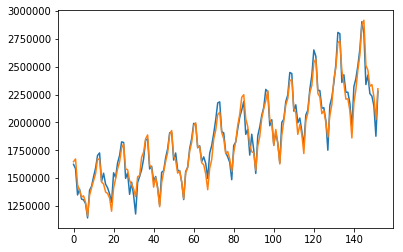

In [566]:
plt.plot(gru2_y)
plt.plot(gru2_train_pred)

In [585]:
gru2_predictions = rolling_predict(gru2_y, gru2, 12, 48)

future['Predictions_2'] = gru2_predictions

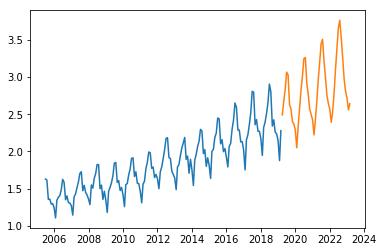

In [621]:
# gru2 was retrained on all available time series data (minus validation), while gru was trained only on train set
# plt.figure(figsize=(13,7))
# plt.title('Departures (in millions)', fontsize=30)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(fontsize=17)
# plt.yticks(fontsize=17)
# plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions_2'] / 1000000);

# GRU 3 (no validation data separate on the test data)

In [581]:
gru3_X, gru3_y = split_sequence(dp_airport['Passenger Count'], 12)
gru3_X = gru3_X.reshape(gru3_X.shape[0], gru3_X.shape[1], 1)

In [711]:
gru3 = Sequential()

# Start with simple model - 1 or 2 layers. Fiddle with dropouts, batch size, epochs
# Length of training data, how far back the window goes, # of features to predict
gru3.add(GRU(128, activation='relu', input_shape=(12,1), return_sequences=True))
gru3.add(GRU(128, activation='relu', input_shape=(32,1)))
gru3.add(Dense(64))
# gru3.add(Dropout(0.08))
gru3.add(Dense(32))
gru3.add(Dense(16))
# gru3.add(Dropout(0.08))
gru3.add(Dense(1))


gru3.compile(optimizer = 'adam', loss = 'mae', )
# lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
gru3.fit(gru3_X, gru3_y, shuffle=False, batch_size=32, epochs=300)

Epoch 1/300
153/153 [==============================] - 10s 63ms/step - loss: 1760694.9281
Epoch 2/300
153/153 [==============================] - 0s 1ms/step - loss: 1402161.2288
Epoch 3/300
153/153 [==============================] - 0s 1ms/step - loss: 842188.3170
Epoch 4/300
153/153 [==============================] - 0s 1ms/step - loss: 266982.2271
Epoch 5/300
153/153 [==============================] - 0s 1ms/step - loss: 313815.8709
Epoch 6/300
153/153 [==============================] - 0s 1ms/step - loss: 204282.8444
Epoch 7/300
153/153 [==============================] - 0s 1ms/step - loss: 263252.5460
Epoch 8/300
153/153 [==============================] - 0s 1ms/step - loss: 153111.6658
Epoch 9/300
153/153 [==============================] - 0s 1ms/step - loss: 144278.9033
Epoch 10/300
153/153 [==============================] - 0s 1ms/step - loss: 173337.9573
Epoch 11/300
153/153 [==============================] - 0s 1ms/step - loss: 135380.8769
Epoch 12/300
153/153 [===============

153/153 [==============================] - 0s 783us/step - loss: 95897.4096
Epoch 94/300
153/153 [==============================] - 0s 774us/step - loss: 95240.2588
Epoch 95/300
153/153 [==============================] - 0s 797us/step - loss: 93951.3168
Epoch 96/300
153/153 [==============================] - 0s 798us/step - loss: 93026.4015
Epoch 97/300
153/153 [==============================] - 0s 849us/step - loss: 91820.5131
Epoch 98/300
153/153 [==============================] - 0s 805us/step - loss: 91024.4707
Epoch 99/300
153/153 [==============================] - 0s 781us/step - loss: 91740.2896
Epoch 100/300
153/153 [==============================] - 0s 923us/step - loss: 88683.6522
Epoch 101/300
153/153 [==============================] - 0s 754us/step - loss: 88032.9088
Epoch 102/300
153/153 [==============================] - 0s 731us/step - loss: 89727.8257
Epoch 103/300
153/153 [==============================] - 0s 735us/step - loss: 85867.6019
Epoch 104/300
153/153 [=======

153/153 [==============================] - 0s 822us/step - loss: 59402.8240
Epoch 185/300
153/153 [==============================] - 0s 791us/step - loss: 70206.0815
Epoch 186/300
153/153 [==============================] - 0s 758us/step - loss: 72816.5437
Epoch 187/300
153/153 [==============================] - 0s 765us/step - loss: 59107.2477
Epoch 188/300
153/153 [==============================] - 0s 790us/step - loss: 69129.3903
Epoch 189/300
153/153 [==============================] - 0s 873us/step - loss: 69698.0816
Epoch 190/300
153/153 [==============================] - 0s 867us/step - loss: 63847.1571
Epoch 191/300
153/153 [==============================] - 0s 807us/step - loss: 56118.6590
Epoch 192/300
153/153 [==============================] - 0s 866us/step - loss: 64023.0401
Epoch 193/300
153/153 [==============================] - 0s 800us/step - loss: 70132.2786
Epoch 194/300
153/153 [==============================] - 0s 780us/step - loss: 65308.7352
Epoch 195/300
153/153 [=

153/153 [==============================] - 0s 839us/step - loss: 57510.3052
Epoch 276/300
153/153 [==============================] - 0s 793us/step - loss: 58577.0491
Epoch 277/300
153/153 [==============================] - 0s 785us/step - loss: 58230.2233
Epoch 278/300
153/153 [==============================] - 0s 780us/step - loss: 58086.4849
Epoch 279/300
153/153 [==============================] - 0s 841us/step - loss: 58451.1990
Epoch 280/300
153/153 [==============================] - 0s 878us/step - loss: 55664.8102
Epoch 281/300
153/153 [==============================] - 0s 927us/step - loss: 58439.1588
Epoch 282/300
153/153 [==============================] - 0s 1ms/step - loss: 61651.3075
Epoch 283/300
153/153 [==============================] - 0s 798us/step - loss: 54664.6103
Epoch 284/300
153/153 [==============================] - 0s 823us/step - loss: 61011.1530
Epoch 285/300
153/153 [==============================] - 0s 922us/step - loss: 56380.0924
Epoch 286/300
153/153 [===

In [712]:
gru3_predictions = rolling_predict(gru3_y, gru3, 12, 48)

future['Predictions_3'] = gru3_predictions

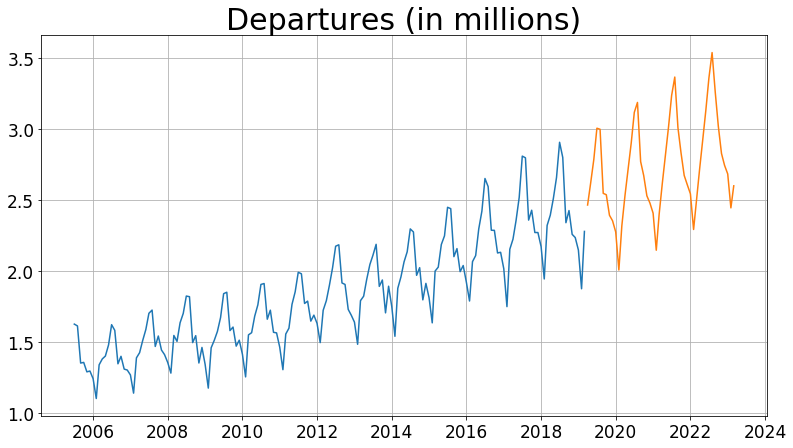

In [714]:
plt.figure(figsize=(13,7))
plt.title('Departures (in millions)', fontsize=30)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.grid(b=True)
plt.plot(dp_airport.index, dp_airport / 1000000)
plt.plot(future['ds'], future['Predictions_3'] / 1000000);

### The first GRU is for tweaking the model hyperparameters and architecture, and getting the test score. GRU2 and GRU3 are both for predicting the future, but GRU2 withholds the last 2 years as validation, while GRU3 is trained on everything

# Growth rates

In [713]:
# Printing out the percentage of total growth from 4 years out to 
print(future.iloc[-12:, 1].sum() / dp_airport[-12:].sum()) # GRU
print(future.iloc[-12:, 2].sum() / dp_airport[-12:].sum()) # GRU2
print(future.iloc[-12:, 3].sum() / dp_airport[-12:].sum()) # GRU3


print((future.iloc[-12:, 1].sum() - dp_airport[-12:].sum()) / 4)
print((future.iloc[-12:, 2].sum() - dp_airport[-12:].sum()) / 4)
print((future.iloc[-12:, 3].sum() - dp_airport[-12:].sum()) / 4)

Passenger Count    1.138859
dtype: float64
Passenger Count    1.289045
dtype: float64
Passenger Count    1.222203
dtype: float64
Passenger Count    1000785.0
dtype: float64
Passenger Count    2.083209e+06
dtype: float64
Passenger Count    1.601460e+06
dtype: float64


The difference is an 18% growth rate from the 4th year to the last year on record, compared to 26%!

# Time series on Passenger Difference (for each of 15 airlines - to predict)

Here I am predicting the seasonality of the difference in passengers coming in and out of SFO (not the seasonality of departures or arrivals themselves).

This prediction could be useful for the airlines themselves (sales forecasting) or for consumers (general ideas of which airlines are the least busy - if you want cheap tickets or to fly on planes that have less passengers, and more overhead baggage space).

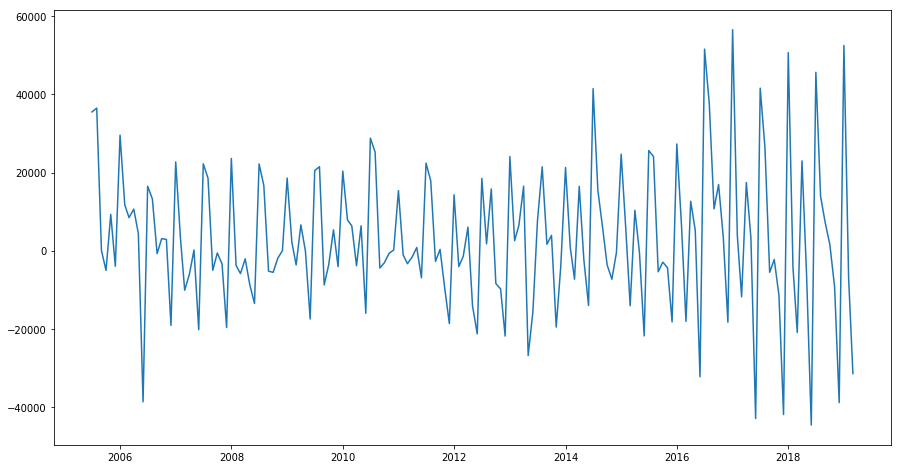

In [185]:
plt.figure(figsize = (15,8))
plt.plot(df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'date'],
         df_grouped.loc[df_grouped['Operating Airline'] == 'United Airlines', 'Passenger Count Difference']);